In [1]:
%pip install cv2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import matplotlib.pylab as plt
import numpy as np

# Resize with OpenCV

In [4]:
coarse_hr = plt.imread('coarse_test.png') # exported img from coarsen.ipynb
coarse_hr.shape

(484, 794, 4)

Resize so that each pixel is exactly 1 block

In [5]:
factor = 32 # orig image was 640x480 . this image is 25x15
downscaled_image = cv2.resize(coarse_hr, (coarse_hr.shape[1] // factor, coarse_hr.shape[0] // factor), interpolation=cv2.INTER_NEAREST)

In [6]:
downscaled_image.shape

(15, 24, 4)

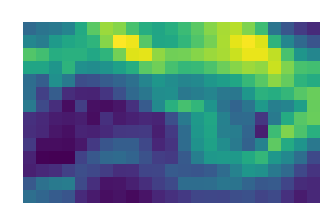

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(downscaled_image)
ax.axis('off')
plt.show()

In [8]:
bilinear = cv2.resize(downscaled_image, (200, 120), interpolation = cv2.INTER_LINEAR)
bicubic = cv2.resize(downscaled_image, (200, 120), interpolation = cv2.INTER_CUBIC)

Plot example interpolation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


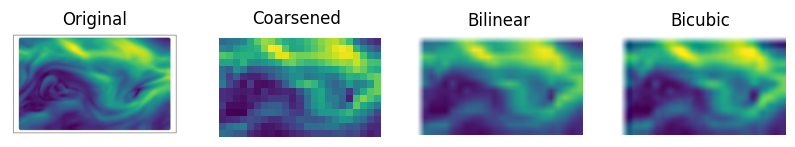

In [9]:
fig, axes = plt.subplots(1,4, figsize=(10,15))
orig = plt.imread('orig.png')
axes[0].imshow(orig)
axes[0].axis('off')
axes[0].set_title("Original")
axes[1].imshow(downscaled_image)
axes[1].axis('off')
axes[1].set_title("Coarsened")
axes[2].imshow(bilinear)
axes[2].axis('off')
axes[2].set_title("Bilinear")
axes[3].imshow(bicubic)
axes[3].axis('off')
axes[3].set_title("Bicubic")
plt.show()

# Resize directly from ERA data

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [11]:
t = np.load('ERA_wind\\ERA_wind.npz')

Pick a sample image, preprocess

In [12]:
lat = t.get('lat')[:120] # dropping the last pixel because it makes reshaping easier
lon = t.get('lon')[:200]
x_grid, y_grid = np.meshgrid(lon, lat, indexing='xy')
x_values = x_grid.flatten()
y_values = y_grid.flatten()
u = t.get('wind_u')[200][1][:120, :200]
v = t.get('wind_v')[200][1][:120, :200]

In [13]:
u.shape

(120, 200)

In [14]:
wind_speed = np.sqrt(u**2 + v**2)
# 120x200 wind speeds
wind_speed_flat = wind_speed.flatten()

Text(0.5, 1.0, 'Bicubic')

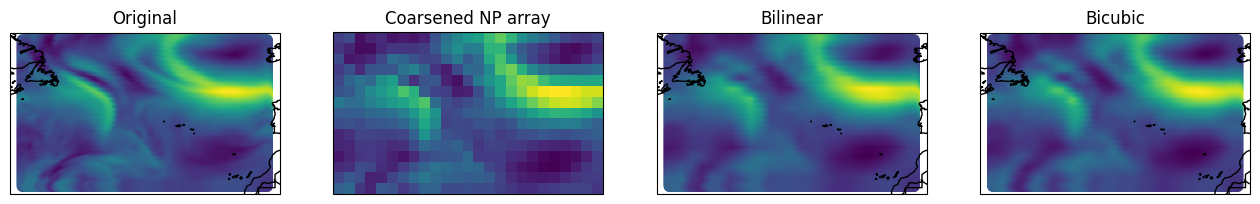

In [15]:
fig, axes = plt.subplots(1,4, figsize=(16,24), subplot_kw={'projection': ccrs.PlateCarree()})

# plot orig
scatter_plot = axes[0].scatter(x_values, y_values, c=wind_speed_flat, cmap='viridis', s=50, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].add_feature(cfeature.BORDERS)
axes[0].set_title("Original")

# plot coarsened
coarse_wind = np.zeros((121 // 8, 201 // 8))
for i in range(0, 120, 8):
    for j in range(0, 200, 8):
        block = wind_speed[i:i+8, j:j+8]
        average = np.mean(block)
        coarse_wind[i // 8, j // 8] = average

axes[1].imshow(coarse_wind, cmap='viridis', interpolation='nearest')
axes[1].set_title('Coarsened NP array')

# plot bicubic, bilinear interpolations
bilinear = cv2.resize(coarse_wind, (200, 120), interpolation = cv2.INTER_LINEAR)
scatter_plot = axes[2].scatter(x_values, y_values, c=bilinear, cmap='viridis', s=50, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].add_feature(cfeature.BORDERS)
axes[2].set_title("Bilinear")

bicubic = cv2.resize(coarse_wind, (200, 120), interpolation = cv2.INTER_CUBIC)
scatter_plot = axes[3].scatter(x_values, y_values, c=bicubic, cmap='viridis', s=50, transform=ccrs.PlateCarree())
axes[3].coastlines()
axes[3].add_feature(cfeature.BORDERS)
axes[3].set_title("Bicubic")

In [16]:
wind_speed.shape, coarse_wind.shape, bilinear.shape, bicubic.shape

((120, 200), (15, 25), (120, 200), (120, 200))

In [17]:
bilinear_data = np.zeros(shape = (149,200*120))
bicubic_data = np.zeros(shape = (149,200*120))
wind_speed_data = np.zeros(shape = (149,200*120))

for time in range(0,149):
    u = t.get('wind_u')[time+595][1][:120, :200]
    v = t.get('wind_v')[time+595][1][:120, :200]
    wind_speed = np.sqrt(u**2 + v**2)
    wind_speed_flat = wind_speed.flatten()
    wind_speed_data[time] = wind_speed_flat
    coarse_wind = np.zeros((121 // 8, 201 // 8))
    for i in range(0, 120, 8):
        for j in range(0, 200, 8):
            block = wind_speed[i:i+8, j:j+8]
            average = np.mean(block)
            coarse_wind[i // 8, j // 8] = average
    
    bilinear = cv2.resize(coarse_wind, (200, 120), interpolation = cv2.INTER_LINEAR)
    bicubic = cv2.resize(coarse_wind, (200, 120), interpolation = cv2.INTER_CUBIC)
    bilinear_data[time] = bilinear.flatten()
    bicubic_data[time] = bicubic.flatten()

x = wind_speed_data.flatten() - bilinear_data.flatten()
print(x.shape)

mape_bilinear = (np.abs(wind_speed_data.flatten() - bilinear_data.flatten())/wind_speed_data.flatten()).mean(axis=0)
print(mape_bilinear)
mape_bicubic = (np.abs(wind_speed_data.flatten() - bicubic_data.flatten())/wind_speed_data.flatten()).mean(axis=0)
print(mape_bicubic)

(3576000,)
0.13724660810108924
0.09778524040676466


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Flatten the arrays before fitting the scaler
wind_speed_data_flattened = wind_speed_data.flatten().reshape(-1, 1)
bilinear_data_flattened = bilinear_data.flatten().reshape(-1, 1)

# Fit the scaler on wind_speed_data_flattened
scaler.fit(wind_speed_data_flattened)

# Transform wind_speed_data and bilinear_data using the fitted scaler
wind_speed_data_normalized = scaler.transform(wind_speed_data_flattened).reshape(wind_speed_data.shape)
bilinear_data_normalized = scaler.transform(bilinear_data_flattened).reshape(bilinear_data.shape)

In [19]:
scaler2 = StandardScaler()

# Flatten the arrays before fitting the scaler
wind_speed_data_flattened = wind_speed_data.flatten().reshape(-1, 1)
bicubic_data_flattened = bicubic_data.flatten().reshape(-1, 1)

# Fit the scaler on wind_speed_data_flattened
scaler2.fit(wind_speed_data_flattened)

# Transform wind_speed_data and bilinear_data using the fitted scaler
wind_speed_data_normalized = scaler2.transform(wind_speed_data_flattened).reshape(wind_speed_data.shape)
bicubic_data_normalized = scaler2.transform(bicubic_data_flattened).reshape(bicubic_data.shape)

In [20]:
from metrics import *
from sklearn.metrics import mean_squared_error

print(wind_speed_data[0:5])
print(bilinear_data[0:5])

mse_bilinear = mean_squared_error(wind_speed_data_normalized, bilinear_data_normalized)
print(mse_bilinear)
mse_bicubic = mean_squared_error(wind_speed_data_normalized, bicubic_data_normalized)
print(mse_bicubic)
js_dist = get_js_distance(wind_speed_data_normalized, bilinear_data_normalized)
print(js_dist)

js_dist3 = get_js_distance(wind_speed_data_normalized, bicubic_data_normalized)
print(js_dist3)


[[19.90289645 19.90562823 19.89438968 ...  5.09091511  4.98845112
   4.90000021]
 [19.65509878 19.55716833 19.44405497 ...  4.32438607  4.1383274
   4.03431883]
 [20.56668162 20.05431657 19.72405399 ...  3.70688605  3.31246261
   3.16897878]
 [23.00292801 22.76143838 22.36787801 ...  2.59574512  2.01763976
   1.8059972 ]
 [20.38553686 20.36892312 20.35282303 ...  2.57791049  1.95224118
   1.62706367]]
[[17.87132986 17.87132986 17.87132986 ...  5.70558593  5.70558593
   5.70558593]
 [19.11142504 19.11142504 19.11142504 ...  5.34988408  5.34988408
   5.34988408]
 [19.78817878 19.78817878 19.78817878 ...  5.21686878  5.21686878
   5.21686878]
 [19.12315946 19.12315946 19.12315946 ...  4.35787245  4.35787245
   4.35787245]
 [17.44931495 17.44931495 17.44931495 ...  4.58428131  4.58428131
   4.58428131]]
0.022942009508410934
0.013328332270282293
0.04895232194402513
0.022052454446176966
